# Welcome to IonNet!

This notebook contains a worked example of how to sample trajectories and train a model for nanochannel water density estimation.

The cell below imports all of the relevant packages and functions we will need.

In [1]:
# Import necessary code from the IonNet repository
from model import *
from solv_utils import *

# Numerical/data handling imports
import numpy as np
import pandas as pd
import mdtraj as md
from sklearn import metrics

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import dataset, DataLoader

# Plotting, i/o, and misc imports
import matplotlib.pyplot as plt
import os, math, glob
from random import sample
from tqdm import tqdm

## Sampling data from our Molecular Dynamics trajectories

### Predefined values and helper functions

This cell has the Lennard-Jones parameters for the atoms used in simulation and data loading functions. The data loading also calculates the density for uniformly sampled vectors.

In [2]:
# Predefined Lennard-Jones parameters for various atoms
LJ = {
    'NA': ['0.3526', '2.1600'],
    'CL': ['0.0128', '4.8305'],
    'MG': ['0.8750', '2.1200'],
    'LI': ['0.3367', '1.4094'],
    'K':  ['0.4297', '2.8384']
}

# Load data using mdtraj
def loadTraj(fname):
    
    # Use PDB file, not lammps trajectory file
    topPath = fname.replace('simulation/traj', 'pdb/ionized/').replace('lammpstrj', 'pdb')
    traj = md.load(fname, top=topPath)
    return traj

# Sample
def sample_single(trajName, ionType, gap, conc):
    
    # Load the trajectory with mdtraj
    traj = loadTraj(trajName)
    
    # Get the topology for easier data collection
    top = traj.topology
    
    # Get only the ions of interest
    ions = top.select('resname %s'%ionType)
    
    # Get opm coordinates and stack into a numpy array
    ion_coords = traj.xyz[:, ions, -1]
    ion_coords = np.hstack(ion_coords)
    
    # Get...
    gra = top.select('resname GRA')
    
    # Center ion coordinates at 0
    center = np.mean(traj.xyz[0, gra, -1])
    ion_coords = np.abs(ion_coords-center)

    # Add ion charge
    if ionType == 'CL':
        charge = -1
    elif ionType == 'MG':
        charge = 2
    else:
        charge = 1
        
    # Get Lennard-Jones parameters
    eps, sig = LJ[ionType]

    # Get randomly sampled vectors for density calculation
    dist1 = np.random.uniform(0, center+0.1, size=800)
    dist2 = np.random.uniform(max(0, center-0.5), center, size=800)
    dist = np.hstack((dist1, dist2))
    
    # Calculate and store densities
    output = []
    for r in dist:
        # Calculate density at radius r
        p = np.sum(ion_coords<r)/len(ion_coords)
        
        # Store density and ion information
        output.append([r, gap, conc, float(sig), float(eps), charge, p])
        
    output=np.array(output)
    return output

## Sampling data and saving for training

Here we gather the data for the simulations we run. Note that data from some gaps and concentrations are specifically excluded from the training set in order to test generalizeability of our model.

In [3]:
# Nano channel gap values we will use for test data
test_gap = set(['1.6', '2.0', '2.4', '2.8'])

# Ion concentration values we will use for test data
test_conc = set(['1.4', '2.2', '3'])

# Get the name of ions we will use
ions = list(LJ.keys())
gap = [0.8+i*0.1 for i in range(23)]
conc = [0.8+i*0.2 for i in range(15)]

# Get all combinations of ion type, gap size, and ion concentration
comb = []
for i in ions:
    for g in gap:
        for c in conc:
            comb.append((i, g, c))

# Load data for each combination of ion type, gap size, and ion concentration
train_data = []
test_data = []

for (ion, g, c) in tqdm(comb):

    # Get the PDB file path
    trajName = 'pdb/ionized/%s_%s_%s.pdb'%(ion, f2str(g), f2str(c))
    
    # Load PDB data with mdtraj
    data = sample_single(trajName, ion, g, c)
    
    # Store data in either train or test data
    if f2str(g) in test_gap or f2str(c) in test_conc:
        test_data.append(data)
    else:
        train_data.append(data)
        
# Convert data to a single numpy array
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)

# Save data
np.savez('data/sampled_train.npz', data=train_data)
np.savez('data/sampled_test.npz', data=test_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1725/1725 [03:36<00:00,  7.96it/s]


## Data Handling

Pytorch contains many useful modules for handling data. The modules here will handle batching and shuffling to make training easier.

### Creating datasets for model training

We first need to load the data, split it into train and validation sets, then initialize our custom data set object that will handle returning features and targets.

In [4]:
# Load training data
data = np.load('data/sampled_train.npz')['data']

# Split data into training and validation splits to aid in model selection
train_data, valid_data= split_data(
        data, valid_ratio = 0.00,
        randomSeed = 2022
)

# Load test data
test_data = np.load('data/sampled_test.npz')['data']

# Create our custom Ion Datasets. This class handles returning data as features and targets
train_dataset = IonDataset(data = train_data)
valid_dataset = IonDataset(data = valid_data)
test_dataset = IonDataset(data = test_data)

The random seed is:  2022
Train size: 1920000, Validation size: 0


### Creating data loaders

The data loaders will handle all batching and shuffling for us.

In [5]:
# DataLoaders allow us to iterate over the dataset where shuffling and batching is handled for us
train_loader = DataLoader(
    train_dataset,      # Our custom dataset object that will return features and targets
    batch_size=1024,    # Batch size is the number of samples we average over for each gradient step
    num_workers=0,      # Workers can load data in parallel, which can be useful for large data sets
    drop_last=False,    # The last batch may not be the full batch_size, but we can still use it for training
    shuffle=True        # Shuffle the data to satisfy IID assumption of gradient based optimizers
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)
print('Train size =\t\t', len(train_data))
print('Validation size =\t', len(valid_data))
print('Test size =\t\t', len(test_data))

Train size =		 1920000
Validation size =	 1920000
Test size =		 840000


## Model Training

Now onto model training. All necessary training parameters are initialized here. With the parameters, we can do training and validation in our training loop.

### Set up our model and optimizer for training

In this cell we initialize our model and set up the optimizer for training. Optimizer hyperparameters can greatly influence training results and must be chosen carefully.

In [6]:
# Set our device to use the cuda-based GPU if it is available
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'

# Loss function
criterion = nn.MSELoss()

# Initialize our model
model = IonNet(n_in=6, activation='ReLU').to(device)

# Use the popular Adam optimizer with our model
optimizer = optim.Adam(
               model.parameters(),  # Pass in our model parameters that we are training
               lr=0.005,            # Learning rate controls how large the step size is
               weight_decay=0       # Weight decay helps minimize overfitting
)

# Learning rate schedulers often help with training
scheduler = StepLR(
              optimizer,       # Pass in our optimizer that we will modify as training progresses
              step_size=1000,  # Modify learning rate after every step_size training steps
              gamma=0.1        # Multiply our learning rate by gamma after every step_size training steps
)

# This folder is where we will store our model during training
model_checkpoints_folder = os.path.join('train/', 'NN')

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




### Training setup

In this cell we set our number of epochs, how often we would like to log our results, and the metrics we will use for model selection.

In [7]:
# How many complete passes over the data we will do during training
n_epochs=10

# How often we would like to print out training progress. This prints after every log_every batches
log_every = 500

# How often we would like to calculate validation loss for our model
val_every = 1  # Validate model after every epoch

# Initialize best values to be worst case possible
best_valid_loss = np.inf  # We are looking for minimum validation loss
best_valid_mae = np.inf   # We are looking for minimum validation MAE
best_valid_roc_auc = 0    # We are looking for maximum validation ROC

### Training loop

Now we are ready to train our model. We take optimizer steps on our training set, but not our validation set. Performance on the validation set allows us to select the model parameters that perform best for testing.

In [8]:
# Run training for n_epochs total passes over the data
for epoch_counter in range(n_epochs):
    
    # Set our model to training mode when learning from training data
    model.train()
    for bn, (inputs, target) in enumerate(train_loader):

        # Put our training features and targets on either CPU or GPU
        input_var = inputs.to(device)
        target = target.to(device)
        
        # Do forward pass through our model to compute its prediction
        output = model(input_var)

        # Calculate loss from current prediction
        loss = criterion(output, target)


        # Always zero gradients before calculating them from the next batch
        optimizer.zero_grad()
        
        # Do backpropagation pass to compute gradients from current batch
        loss.backward()
        
        # Use our optimizer to take a gradient step on our model parameters
        optimizer.step()
        
        # Print out our training progress every log_every steps
        if bn % log_every == 0:
            print('Epoch: %d, Batch: %d, Loss:'%(epoch_counter+1, bn), loss.item())
            
    # Take a step on our optimizer scheduler. Reduces learning rate every step_size steps
    scheduler.step()

    # validate the model if requested
    if epoch_counter % val_every == 0:
        
        # Initialize loss average objects to track loss over entire validation set
        losses = AverageMeter()
        mae_errors = AverageMeter()
        
        # Use no_grad context to increase computational efficiency and ensure 
        # we are not training on validation data
        with torch.no_grad():
            
            # Switch model to evaluation mode so that parameters are not updated on validation data
            model.eval()
            
            # Do pass over validation set
            for bn, (inputs, target) in enumerate(valid_loader):
                
                # Put our validation features and targets on either CPU or GPU
                input_var = inputs.to(device)
                target = target.to(device)
                
                # Do forward pass through our model to compute its prediction
                output = model(input_var)
                
                # Calculate loss. Note that no backward pass is done here because we are validating our model
                loss = criterion(output, target)
                
                # Calculate MAE error and add it to average meter
                mae_error = mae(output, target)
                mae_errors.update(mae_error, target.size(0))

            # Print the validation results
            print('Epoch [{0}] Validate: [{1}/{2}], '
                    'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                epoch_counter+1, bn+1, len(valid_loader),
                mae_errors=mae_errors))

        # Save our model parameters if our validation MAE is a new minimum
        if mae_errors.avg < best_valid_mae:
            best_valid_mae = mae_errors.avg
            
            # Save our model's state dictionary to the path defined earlier
            torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))


Epoch: 1, Batch: 0, Loss: 0.09157299995422363
Epoch: 1, Batch: 500, Loss: 0.008880367502570152
Epoch: 1, Batch: 1000, Loss: 0.00843050517141819
Epoch: 1, Batch: 1500, Loss: 0.007863802835345268
Epoch [1] Validate: [1875/1875], MAE 0.062 (0.064)
Epoch: 2, Batch: 0, Loss: 0.007876944728195667
Epoch: 2, Batch: 500, Loss: 0.006871750112622976
Epoch: 2, Batch: 1000, Loss: 0.006923398934304714
Epoch: 2, Batch: 1500, Loss: 0.007899105548858643
Epoch [2] Validate: [1875/1875], MAE 0.058 (0.061)
Epoch: 3, Batch: 0, Loss: 0.007798407226800919
Epoch: 3, Batch: 500, Loss: 0.00649535097181797
Epoch: 3, Batch: 1000, Loss: 0.006353631615638733
Epoch: 3, Batch: 1500, Loss: 0.005683566443622112
Epoch [3] Validate: [1875/1875], MAE 0.056 (0.058)
Epoch: 4, Batch: 0, Loss: 0.006030443124473095
Epoch: 4, Batch: 500, Loss: 0.005452586337924004
Epoch: 4, Batch: 1000, Loss: 0.005296275485306978
Epoch: 4, Batch: 1500, Loss: 0.005139707121998072
Epoch [4] Validate: [1875/1875], MAE 0.048 (0.049)
Epoch: 5, Batch

### Testing our model

This is where we evaluate model performance on data it has not seen yet.

In [9]:
# Load our best model (lowest validation MAE) from the training loop
state_dict = torch.load(os.path.join(model_checkpoints_folder, 'model.pth'), map_location=device)
model.load_state_dict(state_dict)

##
# Do the same forward pass as in validation for our test data
##

# Initialize loss average objects to track loss over entire test set
mae_errors = AverageMeter()

# Use no_grad context to increase computational efficiency and ensure 
# we are not training on test data
with torch.no_grad():

    # Switch model to evaluation mode so that parameters are not updated on test data
    model.eval()
    
    # Do pass over validation set
    for bn, (inputs, target) in enumerate(test_loader):
        
        # Put our test features and targets on either CPU or GPU
        input_var = inputs.to(device)
        target = target.to(device)
        
        # Calculate loss. Note that no backward pass is done here because we are testing our model
        output = model(input_var)
        
        # Calculate MAE error and add it to average meter
        mae_error = mae(output.data, target)
        mae_errors.update(mae_error, target.size(0))

    # Print the test results
    print('Epoch [{0}] Test: [{1}/{2}], '
            'MAE: {mae_errors.avg:.3f}'.format(
        epoch_counter+1, bn+1, len(test_loader),
        mae_errors=mae_errors))


Epoch [10] Test: [821/821], MAE: 0.072


### Vizualizing results

Now that we have evaluated our trained model, we vizualize the results.

In [10]:
# Set the size of the nano channel used for training
gap=2.0

# Set the size of the bins used for CDF/PDF calculation
binSize=0.02
bins = np.array([i*binSize for i in range(int((gap/2+0.1)//binSize))])

# Like in validation and testing, use the no_grad context to speed up computational efficiency and
# ensure we are not training on our new data
with torch.no_grad():
    
    # Switch model to evaluation mode so that parameters are not updated on test data
    model.eval()
    
    # Calculate the CDF value for each bin
    cdf = []
    for b in bins:
        
        # Create a torch tensor of our evaluation data and put it on CPU or GPU
        p = model(torch.tensor([b, gap, 2.2, 4.8305, 0.0128, -1]).float().to(device))
        
        # Make sure our prediction is back on the CPU and a data type that can be plotted easily
        p = p.cpu().numpy()
        
        # Hold on to prediction
        cdf.append(p)
        
    # Make PDF calculation easier then calculate is
    cdf = np.array(cdf)
    pdf = cdf[1:]-cdf[:-1]

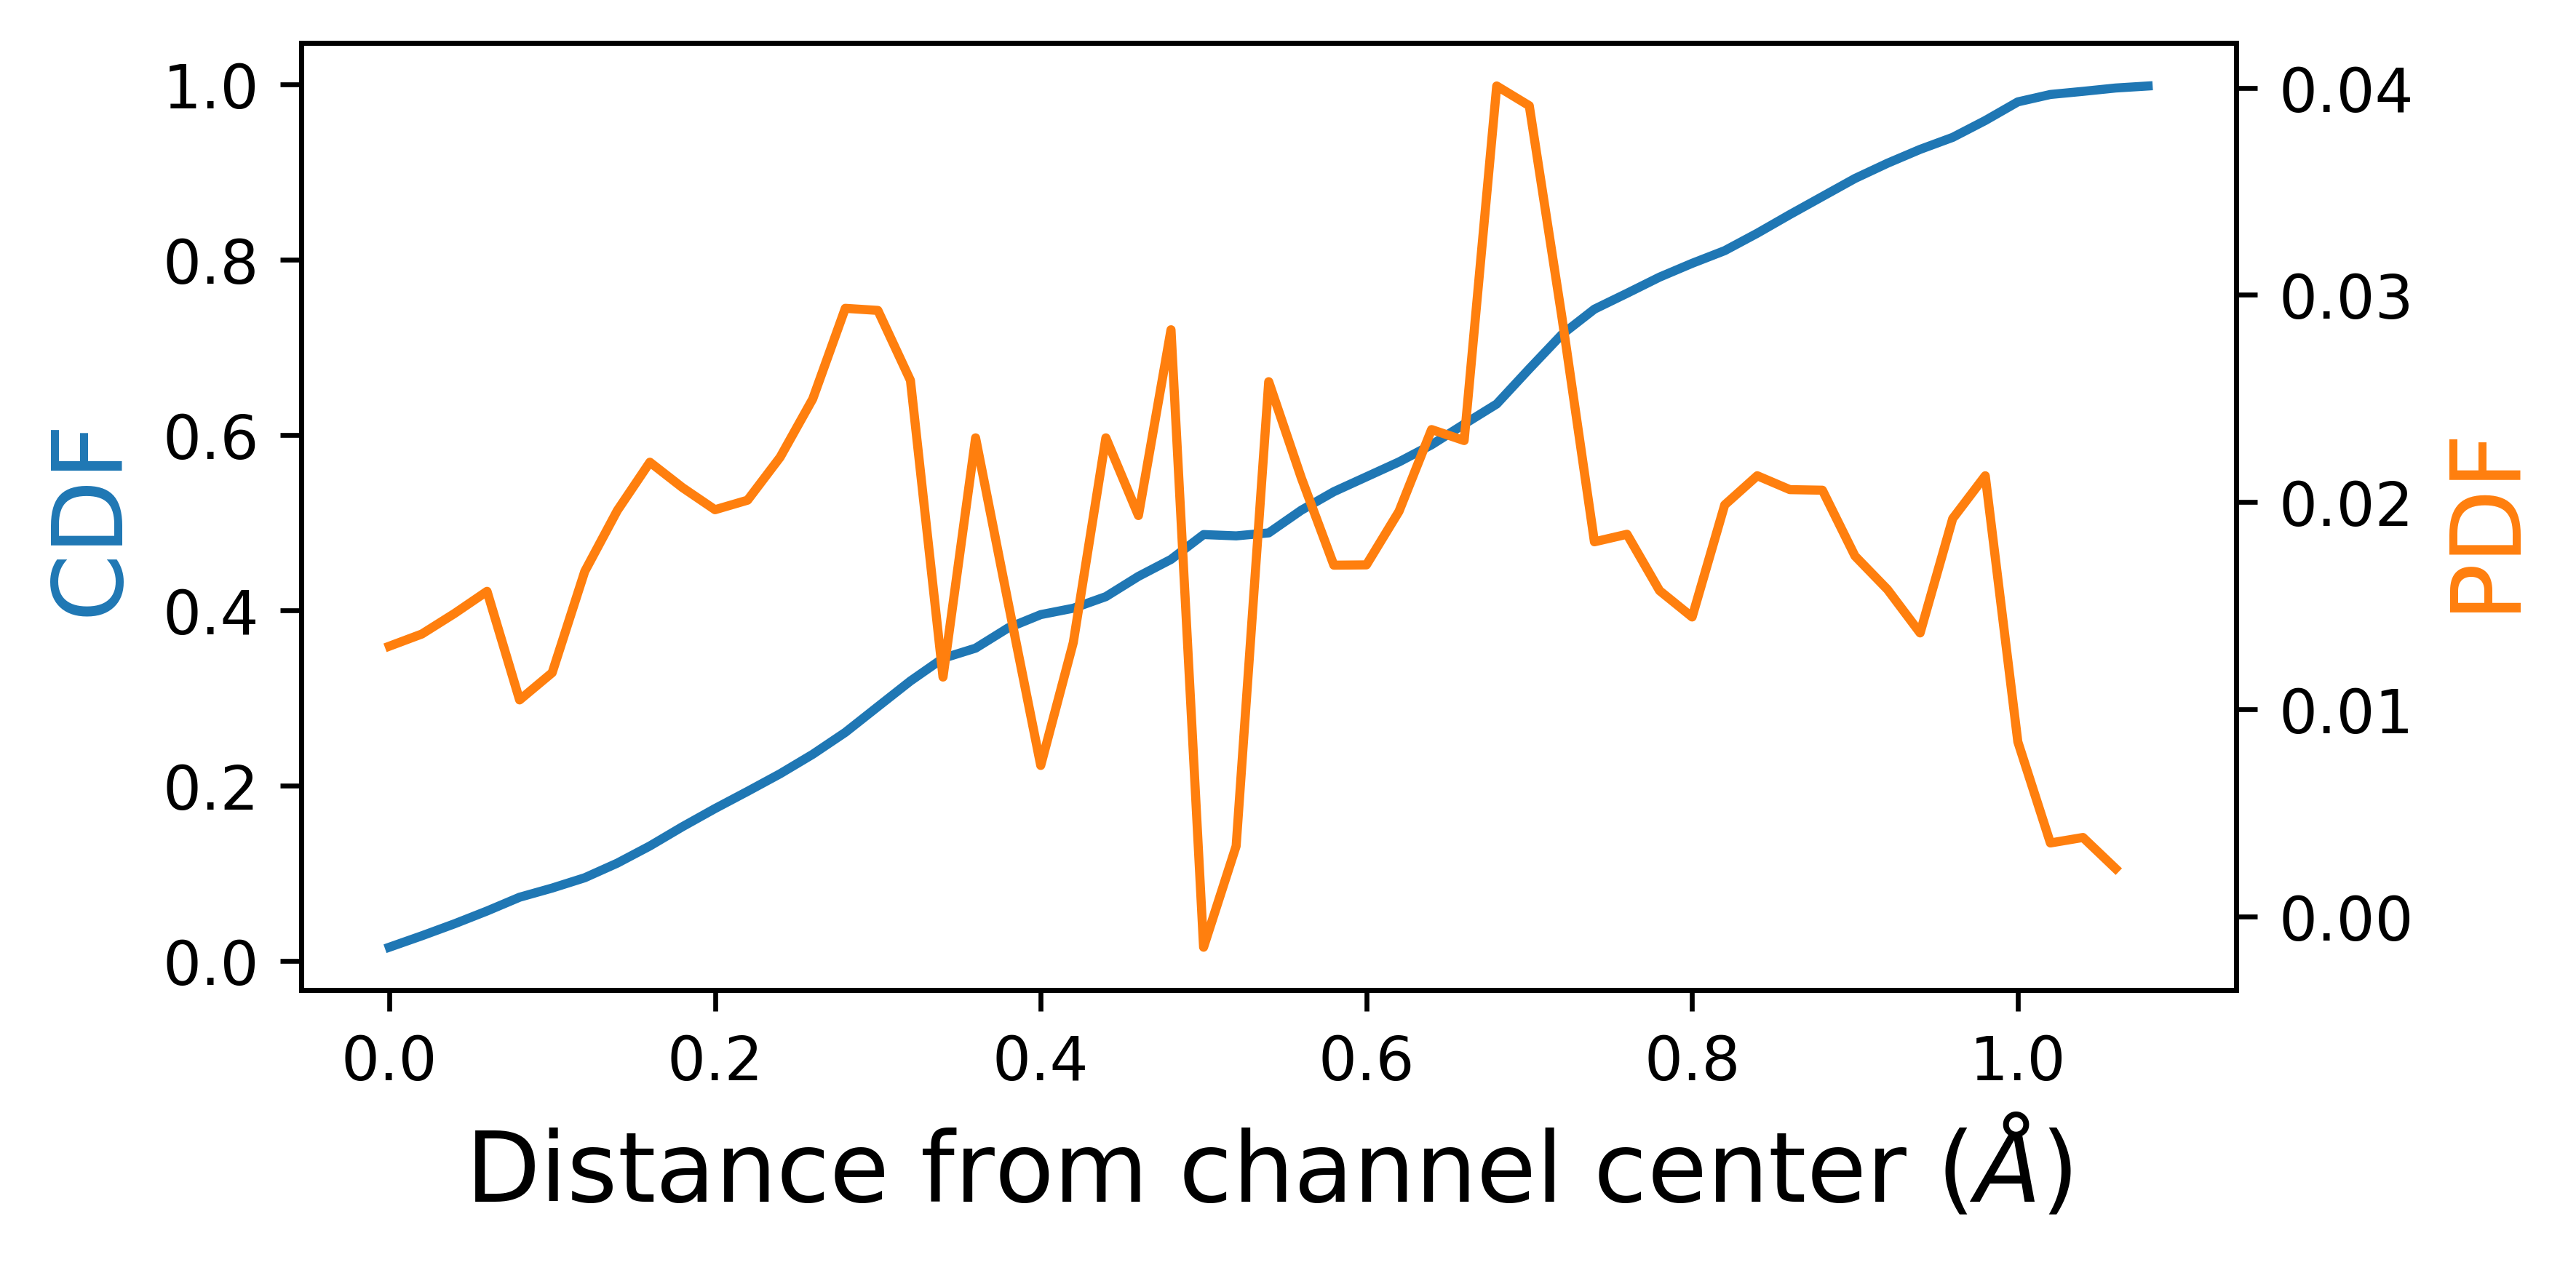

In [11]:
# Plot PDF and CDF with matplotlib
fig, ax = plt.subplots(figsize = (6, 3), dpi=600)
ax2 = ax.twinx()

# Plot our model's predicted CDF and PDF
ax.plot(bins, cdf, color = 'C0')
ax2.plot(bins[:-1], pdf, color = 'C1')
 
# giving labels to the axises
ax.set_xlabel('Distance from channel center ($\AA$)', fontsize=16)
ax.set_ylabel('CDF', color = 'C0', fontsize=16)
ax2.set_ylabel('PDF', color = 'C1', fontsize=16)
 
# defining display layout
plt.tight_layout()